# Codewars Solutions Analysis

## About Codewars

Codewars is a community driven website where users can submit and solve "Kata".

Kata are simply coding problems to be solved.

Codewars features an extensive list of languages allowed, ranging from well established languages to more obscure ones such as Prolog.

Throughout this notebook I scrape all the solutions to the kata I have completed alongside additional information, then analyse the data through a series of visualisations

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import requests
import json
import bs4 as BeautifulSoup
from time import sleep
%matplotlib inline

In [4]:
# Set style to Solarize_Light2, the best style
plt.style.use('Solarize_Light2')

### Load Pre-existing Data

In [5]:
# Load the dataframe from .csv so we can ensure we don't create duplicate entries
# Also so we don't have to scrape the site fully every time we run the notebook
if os.path.isfile('codewars.csv'):
    codewars_df = pd.read_csv('codewars.csv')

## Data Collection

Whilst Codewars does have an API, only the user themselves are able to view their completed Kata
Thus we use a webscraper to download the full solution set
We can query the API for full details about each problem

In [6]:
# Initialise git submodule if it doesn't exist
if not os.path.isdir('codewars_scraper'):
    !git submodule add https://github.com/Eatkin/codewars-scraper.git codewars_scraper

!git submodule update --remote codewars_scraper

In [7]:
# Initialising the git submodule can change our directory so make sure we're back in the correct place
# Also add an init file so we can import the scraper as a module
if os.getcwd().endswith('codewars_scraper'):
    !touch __init__.py
    os.chdir(os.path.dirname(os.getcwd()))
else:
    os.chdir('codewars_scraper')
    !touch __init__.py
    os.chdir(os.path.dirname(os.getcwd()))

os.getcwd()

'/home/ed/code/Eatkin/codewars/codewars-analysis'

### Run the Scraper
You can run the scraper outside this Notebook by running python scraper.py and following the instructions

### Retrieve any New Problems

In [8]:
# Retrieve language filetypes
from codewars_scraper.scraper import language_filetypes
language_filetypes

{'c': '.c',
 'javascript': '.js',
 'python': '.py',
 'shell': '.sh',
 'c#': '.cs',
 'sql': '.sql',
 'bf': '.bf'}

In [9]:
# Import new problems to the data folder
# This is a "dumb" copy, it doesn't check if the problem already exists
import shutil

source_directory = 'codewars_scraper/'
destination_directory = 'data/'

# Iterate over the keys of the language_filetypes dictionary
for language in language_filetypes:
    # Find the matching folder name (case-insensitive)
    matching_folder = next((folder for folder in os.listdir(source_directory) if folder.lower() == language.lower()), None)
    
    # Construct the source and destination paths for the current language
    if matching_folder:
        source_path = os.path.join(source_directory, matching_folder)
        destination_path = os.path.join(destination_directory, matching_folder)

        # This removes the destination directory if it already exists
        if os.path.exists(destination_path):
            shutil.rmtree(destination_path)
    

        # Copy the source directory to the destination directory
        shutil.copytree(source_path, destination_path)

## Looping through data files

In [10]:
# This will loop through every file in the data folder and extract the link
path = "data/"

count = 0

for root, dirs, files in os.walk(path):
    for name in files:
        with open(os.path.join(root, name), 'r') as f:
            link = f.readline().strip()
            count += 1
            
print(f"Found {count} files")

Found 292 files


## Generating dictionary for dataframe

In [11]:
# regex to extract the kata ID
pattern = re.compile(r'^.*kata/(.*)$')
# regex to extract version number
revision_pattern = re.compile(r'.*-v(\d+)-.*')

In [41]:
# Loop through all files to collect kata ID, language and revision numbers
data_list = []

base_url = "https://www.codewars.com/kata/"

# Check if dataframe exists
dataframe_exists = False
if os.path.isfile('codewars.csv'):
    dataframe_exists = True

# loop through files
for root, dirs, files in os.walk(path):
    for name in files:
        with open(os.path.join(root, name), 'r') as f:
            lines = f.readlines()

            # extract problem id from first line of file
            first_line = lines[0].strip()
            problem_id = re.search(pattern, first_line).group(1)
            
            # extract date from second line of file
            date = lines[1].strip()
            # remove comment if it exists
            date = re.search(r"^.*?(\d{4}.*)$", date).group(1)
            date = re.sub(r'T', ' ', date)
            date = re.sub(r'\+\d{4}', '', date)
            
            # Before we continue, check if we already have an entry for this kata
            # The date will be unique, since it's down to the nearest millisecond
            # so we can use that to check
            if dataframe_exists and codewars_df[codewars_df['date_time'] == date].shape[0] > 0:
                continue
            
            # construct link
            link = base_url + problem_id

            # extract language from folder name
            language = os.path.basename(root)

            # extract revision from file name
            match = re.search(revision_pattern, name)
            if match:
                revision = match.group(1)
            else:
                revision = 1

            # extract solution from file contents
            solution = '\n'.join(lines[2:])

            # create dictionary and add to list
            data_dict = {
                'problem_id': problem_id,
                'language': language,
                'revision': int(revision),
                'solution': solution,
                'link': link,
                'date_time': date
            }
            data_list.append(data_dict)

if data_list != []:
    print("Added", len(data_list), "new problems")
else:
    print("No new problems found")

Added 292 new problems


## API Requests

The API requests take the form:
https://www.codewars.com/api/v1/code-challenges/{challenge_id}

The response is of the format:
Field	| Type | Description
| --- | --- | --- |
id | string | ID of the kata.
name | string | Name of the kata.
slug | string | Slug of the kata.
url | string | URL of the kata.
category | string | Category of the kata.
description | string | Description of the kata in Markdown.
tags | string[] | Array of tags associated with the kata.
languages | string[] | Array of language names the kata is available in.
rank | object? | Object describing the rank of the kata if approved.
createdBy | object | The author of the kata.
publishedAt | string | Date and time when the kata was first published.
approvedBy | object? | The approver of the kata.
approvedAt | string | Date and time when the kata was approved.
totalCompleted | number | Total number of completions.
totalAttempts | number | Total number of attempts.
totalStars | number | The number of bookmarks.
voteScore | number | The sum of all votes casted.
contributorsWanted | boolean | Whether to allow contributions.
unresolved | object | Object with fields issues and suggestions for the number of unresolved issues and suggestions respectively.

### Test API Request

#### Test With "Hello World" kata

In [42]:
# We want to retrieve name, rank, totalAttempts, totalCompleted, createdBy, publishedAt, category, totalStars, voteScore, unresolved, tags
URL = 'https://www.codewars.com/api/v1/code-challenges/'
problem_id = '523b4ff7adca849afe000035'
response = requests.get(URL + problem_id)
if response.status_code == 200:
    print(json.dumps(response.json(), indent=4))

{
    "id": "523b4ff7adca849afe000035",
    "name": "Function 1 - hello world",
    "slug": "function-1-hello-world",
    "category": "reference",
    "publishedAt": "2013-09-19T20:36:41.798Z",
    "approvedAt": null,
    "languages": [
        "javascript",
        "ruby",
        "python",
        "java",
        "haskell",
        "csharp",
        "elixir",
        "r",
        "php",
        "objc",
        "lua",
        "julia",
        "groovy",
        "go",
        "crystal",
        "dart",
        "powershell",
        "clojure",
        "nasm",
        "coffeescript",
        "c",
        "shell",
        "erlang",
        "rust",
        "prolog",
        "swift",
        "cfml",
        "racket",
        "reason",
        "typescript",
        "elm",
        "purescript",
        "factor",
        "cpp",
        "kotlin",
        "commonlisp",
        "cobol",
        "scala",
        "ocaml",
        "pascal"
    ],
    "url": "https://www.codewars.com/kata/523b4ff7adca

In [43]:
# Retrieve just the information we want:
print("Name:", response.json()['name'])
print("Rank:", response.json()['rank']['name'])
print("Rank category", response.json()['rank']['color'])
print("Total attempts:", response.json()['totalAttempts'])
print("Total completed:", response.json()['totalCompleted'])
print("Created by:", response.json()['createdBy']['username'])
print("Published at:", response.json()['publishedAt'])
print("Category:", response.json()['category'])
print("Total stars:", response.json()['totalStars'])
print("Vote score:", response.json()['voteScore'])
print("Issues:", response.json()['unresolved']['issues'])
print("Suggestions:", response.json()['unresolved']['suggestions'])
print("Tags:", response.json()['tags'])

Name: Function 1 - hello world
Rank: 8 kyu
Rank category white
Total attempts: 423993
Total completed: 187170
Created by: ineiti
Published at: 2013-09-19T20:36:41.798Z
Category: reference
Total stars: 776
Vote score: 7672
Issues: 4
Suggestions: 0
Tags: ['Fundamentals']


#### Retrieve All Problems Information

In [49]:
# Define functions
def get_problem_info(id):
    URL = URL = 'https://www.codewars.com/api/v1/code-challenges/'
    response = requests.get(URL + id)
    if response.status_code == 200:
        return response.json()
    else:
        print("Error retrieving problem info")
        return None
    
def parse_problem(problem_json):
    info_dict = {}
    info_dict['title'] = problem_json['name']
    info_dict['difficulty'] = problem_json['rank']['name']
    info_dict['difficulty_category'] = problem_json['rank']['color']
    info_dict['attempts'] = problem_json['totalAttempts']
    info_dict['completion_count'] = problem_json['totalCompleted']
    # Not all kata have an author
    try:
        info_dict['author'] = problem_json['createdBy']['username']
    except:
        info_dict['author'] = np.nan
    info_dict['tags'] = problem_json['tags']
    info_dict['published_at'] = problem_json['publishedAt']
    info_dict['category'] = problem_json['category']
    info_dict['total_stars'] = problem_json['totalStars']
    info_dict['vote_score'] = problem_json['voteScore']
    info_dict['issues'] = problem_json['unresolved']['issues']
    info_dict['suggestions'] = problem_json['unresolved']['suggestions']
    return info_dict
    

In [50]:
# Loop through all problems and parse the info
problem_num = 0
for problem in data_list:
    problem_num += 1
    # Skip any that have already been parsed
    if 'difficulty' in problem:
        continue
    
    p_id = problem['problem_id']
    
    print("Parsing problem", problem_num, "of", len(data_list))
    print("ID:", p_id)
    
    info = get_problem_info(p_id)
    if info:
        parsed_info = parse_problem(info)
        data_list[problem_num - 1].update(parsed_info)
        
    sleep(5)

Parsing problem 94 of 292
ID: 50654ddff44f800200000004
Parsing problem 95 of 292
ID: 550f22f4d758534c1100025a
Parsing problem 96 of 292
ID: 5981ff1daf72e8747d000091
Parsing problem 97 of 292
ID: 54c27a33fb7da0db0100040e
Parsing problem 98 of 292
ID: 54e6533c92449cc251001667
Parsing problem 99 of 292
ID: 537e18b6147aa838f600001b
Parsing problem 100 of 292
ID: 577a98a6ae28071780000989
Parsing problem 101 of 292
ID: 54521e9ec8e60bc4de000d6c
Parsing problem 102 of 292
ID: 5c511d8877c0070e2c195faf
Parsing problem 103 of 292
ID: 57eaeb9578748ff92a000009
Parsing problem 104 of 292
ID: 54bf1c2cd5b56cc47f0007a1
Parsing problem 105 of 292
ID: 56170e844da7c6f647000063
Parsing problem 106 of 292
ID: 54da5a58ea159efa38000836
Parsing problem 107 of 292
ID: 555086d53eac039a2a000083
Parsing problem 108 of 292
ID: 576757b1df89ecf5bd00073b
Parsing problem 109 of 292
ID: 57e76bc428d6fbc2d500036d
Parsing problem 110 of 292
ID: 56606694ec01347ce800001b
Parsing problem 111 of 292
ID: 5679aa472b8f57fb8c00004

In [52]:
data_list[0]

{'problem_id': '58ce8725c835848ad6000007',
 'language': 'Shell',
 'revision': 1,
 'solution': '#!/bin/bash\n\npi=$1\n\nw=$2\n\npf=$3\n\n\n\necho "$w*(100-$pi)/(100-$pf)" | bc',
 'link': 'https://www.codewars.com/kata/58ce8725c835848ad6000007',
 'date_time': '2023-04-08 15:13:48.626',
 'title': 'Drying Potatoes',
 'difficulty': '7 kyu',
 'difficulty_category': 'white',
 'attempts': 62954,
 'completion_count': 9461,
 'author': 'g964',
 'tags': ['Fundamentals', 'Puzzles'],
 'published_at': '2017-03-19T13:30:31.186Z',
 'category': 'reference',
 'total_stars': 295,
 'vote_score': 522,
 'issues': 2,
 'suggestions': 7}

In [53]:
data_list[-1]

{'problem_id': '557cd6882bfa3c8a9f0000c1',
 'language': 'C#',
 'revision': 1,
 'solution': "using System;\n\n\n\npublic class Kata\n\n{\n\n  public static int GetAge(string inputString)\n\n  {\n\n    return int.Parse(inputString.Split(' ')[0]);\n\n    // return correct age (int). Happy coding :)\n\n  }\n\n}",
 'link': 'https://www.codewars.com/kata/557cd6882bfa3c8a9f0000c1',
 'date_time': '2023-05-03 12:55:15.402',
 'title': 'Parse nice int from char problem',
 'difficulty': '8 kyu',
 'difficulty_category': 'white',
 'attempts': 116281,
 'completion_count': 57737,
 'author': 'Joz',
 'tags': ['Fundamentals'],
 'published_at': '2015-06-14T01:26:21.484Z',
 'category': 'reference',
 'total_stars': 264,
 'vote_score': 3841,
 'issues': 3,
 'suggestions': 2}

### Store Data in Dataframe
Note the dataframe name. This is because codewars_df may already exist
We with to only append new data

In [54]:
# Now we have some new data, let's make a dataframe
new_codewars_df = pd.DataFrame(data_list)
new_codewars_df.head()

,problem_id,language,revision,solution,link,date_time,title,difficulty,difficulty_category,attempts,completion_count,author,tags,published_at,category,total_stars,vote_score,issues,suggestions
0,58ce8725c835848ad6000007,Shell,1,#!/bin/bash\n\npi=$1\n\nw=$2\n\npf=$3\n\n\n\ne...,https://www.codewars.com/kata/58ce8725c835848a...,2023-04-08 15:13:48.626,Drying Potatoes,7 kyu,white,62954,9461,g964,"[Fundamentals, Puzzles]",2017-03-19T13:30:31.186Z,reference,295,522,2,7
1,56bc28ad5bdaeb48760009b0,Shell,1,function removeChar() {\n\n local str=$1\n\n ...,https://www.codewars.com/kata/56bc28ad5bdaeb48...,2023-03-27 11:00:44.662,Remove First and Last Character,8 kyu,white,470694,216076,Steadyx,"[Strings, Fundamentals]",2016-02-11T21:14:31.636Z,reference,1191,13257,3,1
2,59bfe5f15227ddf81900007b,Shell,1,ls -t | head -n 1,https://www.codewars.com/kata/59bfe5f15227ddf8...,2023-04-08 15:20:55.441,Return the latest modified file,7 kyu,white,740,327,ddellaquila,[Fundamentals],2017-09-18T15:38:39.371Z,reference,5,99,1,0
3,582cb0224e56e068d800003c,Shell,1,def litres(time):\n\n return (time * 0.5)//1,https://www.codewars.com/kata/582cb0224e56e068...,2023-04-17 18:06:43.289,Keep Hydrated!,8 kyu,white,297590,155844,paulrichard,"[Algorithms, Mathematics, Fundamentals]",2016-11-16T19:47:07.378Z,reference,738,8784,0,3
4,563a631f7cbbc236cf0000c2,Shell,1,position=$1\n\nroll=$2\n\n# your code here\n\n...,https://www.codewars.com/kata/563a631f7cbbc236...,2023-03-31 06:07:28.588,Grasshopper - Terminal game move function,8 kyu,white,62662,45039,danleavitt0,[Fundamentals],2015-11-07T17:40:01.344Z,reference,152,3129,0,4


In [55]:
new_codewars_df.shape

(292, 19)

In [56]:
new_codewars_df.tail()

,problem_id,language,revision,solution,link,date_time,title,difficulty,difficulty_category,attempts,completion_count,author,tags,published_at,category,total_stars,vote_score,issues,suggestions
287,55a2d7ebe362935a210000b2,C,1,#include <stddef.h>\n\n\n\nint find_smallest_i...,https://www.codewars.com/kata/55a2d7ebe362935a...,2023-03-11 15:50:33.460,Find the smallest integer in the array,8 kyu,white,376946,193744,dukeofgarda,[Fundamentals],2015-07-12T21:11:22.672Z,reference,1061,11098,1,2
288,57a0885cbb9944e24c00008e,C,1,#include <string.h>\n\n\n\n// Write resulting ...,https://www.codewars.com/kata/57a0885cbb9944e2...,2023-03-11 15:56:53.707,Remove exclamation marks,8 kyu,white,174560,73157,wichu,"[Fundamentals, Strings]",2016-08-02T11:48:46.317Z,reference,411,4757,0,1
289,5715eaedb436cf5606000381,C#,1,using System;\n\nusing System.Linq;\n\n\n\npub...,https://www.codewars.com/kata/5715eaedb436cf56...,2023-05-03 14:16:10.209,Sum of positive,8 kyu,white,499455,227767,JbPasquier,"[Arrays, Fundamentals]",2016-04-19T08:23:20.306Z,reference,1593,15331,1,1
290,55cbc3586671f6aa070000fb,C#,1,using System;\n\n\n\npublic class Kata\n\n{\n\...,https://www.codewars.com/kata/55cbc3586671f6aa...,2023-05-03 14:11:40.738,Grasshopper - Check for factor,8 kyu,white,85099,52924,danleavitt0,"[Mathematics, Fundamentals]",2015-09-11T21:20:31.597Z,reference,216,3920,0,3
291,557cd6882bfa3c8a9f0000c1,C#,1,using System;\n\n\n\npublic class Kata\n\n{\n\...,https://www.codewars.com/kata/557cd6882bfa3c8a...,2023-05-03 12:55:15.402,Parse nice int from char problem,8 kyu,white,116281,57737,Joz,[Fundamentals],2015-06-14T01:26:21.484Z,reference,264,3841,3,2


In [57]:
new_codewars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   problem_id           292 non-null    object
 1   language             292 non-null    object
 2   revision             292 non-null    int64 
 3   solution             292 non-null    object
 4   link                 292 non-null    object
 5   date_time            292 non-null    object
 6   title                292 non-null    object
 7   difficulty           292 non-null    object
 8   difficulty_category  292 non-null    object
 9   attempts             292 non-null    int64 
 10  completion_count     292 non-null    int64 
 11  author               291 non-null    object
 12  tags                 292 non-null    object
 13  published_at         292 non-null    object
 14  category             292 non-null    object
 15  total_stars          292 non-null    int64 
 16  vote_sco

### Append New Data to Stored Dataframe
If the dataframe existed before we started, we may have scraped new data to append

In [58]:
# Append new data to the end of the old dataframe
# We need to check the df exists first incase this is the first scrape
if 'codewars_df' in locals():
    codewars_df = codewars_df.append(new_codewars_df, ignore_index=True)
else:
    codewars_df = new_codewars_df

# Free up some memory since it's now stored twice
del new_codewars_df

In [59]:
codewars_df.head()

,problem_id,language,revision,solution,link,date_time,title,difficulty,difficulty_category,attempts,completion_count,author,tags,published_at,category,total_stars,vote_score,issues,suggestions
0,58ce8725c835848ad6000007,Shell,1,#!/bin/bash\n\npi=$1\n\nw=$2\n\npf=$3\n\n\n\ne...,https://www.codewars.com/kata/58ce8725c835848a...,2023-04-08 15:13:48.626,Drying Potatoes,7 kyu,white,62954,9461,g964,"[Fundamentals, Puzzles]",2017-03-19T13:30:31.186Z,reference,295,522,2,7
1,56bc28ad5bdaeb48760009b0,Shell,1,function removeChar() {\n\n local str=$1\n\n ...,https://www.codewars.com/kata/56bc28ad5bdaeb48...,2023-03-27 11:00:44.662,Remove First and Last Character,8 kyu,white,470694,216076,Steadyx,"[Strings, Fundamentals]",2016-02-11T21:14:31.636Z,reference,1191,13257,3,1
2,59bfe5f15227ddf81900007b,Shell,1,ls -t | head -n 1,https://www.codewars.com/kata/59bfe5f15227ddf8...,2023-04-08 15:20:55.441,Return the latest modified file,7 kyu,white,740,327,ddellaquila,[Fundamentals],2017-09-18T15:38:39.371Z,reference,5,99,1,0
3,582cb0224e56e068d800003c,Shell,1,def litres(time):\n\n return (time * 0.5)//1,https://www.codewars.com/kata/582cb0224e56e068...,2023-04-17 18:06:43.289,Keep Hydrated!,8 kyu,white,297590,155844,paulrichard,"[Algorithms, Mathematics, Fundamentals]",2016-11-16T19:47:07.378Z,reference,738,8784,0,3
4,563a631f7cbbc236cf0000c2,Shell,1,position=$1\n\nroll=$2\n\n# your code here\n\n...,https://www.codewars.com/kata/563a631f7cbbc236...,2023-03-31 06:07:28.588,Grasshopper - Terminal game move function,8 kyu,white,62662,45039,danleavitt0,[Fundamentals],2015-11-07T17:40:01.344Z,reference,152,3129,0,4


In [20]:
codewars_df.shape

(292, 11)

### Save Dataframe as CSV

In [60]:
# Save dataframe to csv
codewars_df.to_csv('codewars.csv', index=False)

In [62]:
# Load the dataframe back in from csv
# We do this because the "tags" column is not a list of strings when we save to csv, but it is when we load from csv
codewars_df = pd.read_csv('codewars.csv')

### Inspect Dataframe

In [63]:
codewars_df.head()

,problem_id,language,revision,solution,link,date_time,title,difficulty,difficulty_category,attempts,completion_count,author,tags,published_at,category,total_stars,vote_score,issues,suggestions
0,58ce8725c835848ad6000007,Shell,1,#!/bin/bash\n\npi=$1\n\nw=$2\n\npf=$3\n\n\n\ne...,https://www.codewars.com/kata/58ce8725c835848a...,2023-04-08 15:13:48.626,Drying Potatoes,7 kyu,white,62954,9461,g964,"['Fundamentals', 'Puzzles']",2017-03-19T13:30:31.186Z,reference,295,522,2,7
1,56bc28ad5bdaeb48760009b0,Shell,1,function removeChar() {\n\n local str=$1\n\n ...,https://www.codewars.com/kata/56bc28ad5bdaeb48...,2023-03-27 11:00:44.662,Remove First and Last Character,8 kyu,white,470694,216076,Steadyx,"['Strings', 'Fundamentals']",2016-02-11T21:14:31.636Z,reference,1191,13257,3,1
2,59bfe5f15227ddf81900007b,Shell,1,ls -t | head -n 1,https://www.codewars.com/kata/59bfe5f15227ddf8...,2023-04-08 15:20:55.441,Return the latest modified file,7 kyu,white,740,327,ddellaquila,['Fundamentals'],2017-09-18T15:38:39.371Z,reference,5,99,1,0
3,582cb0224e56e068d800003c,Shell,1,def litres(time):\n\n return (time * 0.5)//1,https://www.codewars.com/kata/582cb0224e56e068...,2023-04-17 18:06:43.289,Keep Hydrated!,8 kyu,white,297590,155844,paulrichard,"['Algorithms', 'Mathematics', 'Fundamentals']",2016-11-16T19:47:07.378Z,reference,738,8784,0,3
4,563a631f7cbbc236cf0000c2,Shell,1,position=$1\n\nroll=$2\n\n# your code here\n\n...,https://www.codewars.com/kata/563a631f7cbbc236...,2023-03-31 06:07:28.588,Grasshopper - Terminal game move function,8 kyu,white,62662,45039,danleavitt0,['Fundamentals'],2015-11-07T17:40:01.344Z,reference,152,3129,0,4


In [64]:
codewars_df.tail()

,problem_id,language,revision,solution,link,date_time,title,difficulty,difficulty_category,attempts,completion_count,author,tags,published_at,category,total_stars,vote_score,issues,suggestions
287,55a2d7ebe362935a210000b2,C,1,#include <stddef.h>\n\n\n\nint find_smallest_i...,https://www.codewars.com/kata/55a2d7ebe362935a...,2023-03-11 15:50:33.460,Find the smallest integer in the array,8 kyu,white,376946,193744,dukeofgarda,['Fundamentals'],2015-07-12T21:11:22.672Z,reference,1061,11098,1,2
288,57a0885cbb9944e24c00008e,C,1,#include <string.h>\n\n\n\n// Write resulting ...,https://www.codewars.com/kata/57a0885cbb9944e2...,2023-03-11 15:56:53.707,Remove exclamation marks,8 kyu,white,174560,73157,wichu,"['Fundamentals', 'Strings']",2016-08-02T11:48:46.317Z,reference,411,4757,0,1
289,5715eaedb436cf5606000381,C#,1,using System;\n\nusing System.Linq;\n\n\n\npub...,https://www.codewars.com/kata/5715eaedb436cf56...,2023-05-03 14:16:10.209,Sum of positive,8 kyu,white,499455,227767,JbPasquier,"['Arrays', 'Fundamentals']",2016-04-19T08:23:20.306Z,reference,1593,15331,1,1
290,55cbc3586671f6aa070000fb,C#,1,using System;\n\n\n\npublic class Kata\n\n{\n\...,https://www.codewars.com/kata/55cbc3586671f6aa...,2023-05-03 14:11:40.738,Grasshopper - Check for factor,8 kyu,white,85099,52924,danleavitt0,"['Mathematics', 'Fundamentals']",2015-09-11T21:20:31.597Z,reference,216,3920,0,3
291,557cd6882bfa3c8a9f0000c1,C#,1,using System;\n\n\n\npublic class Kata\n\n{\n\...,https://www.codewars.com/kata/557cd6882bfa3c8a...,2023-05-03 12:55:15.402,Parse nice int from char problem,8 kyu,white,116281,57737,Joz,['Fundamentals'],2015-06-14T01:26:21.484Z,reference,264,3841,3,2


In [65]:
codewars_df.shape

(292, 19)

In [66]:
codewars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   problem_id           292 non-null    object
 1   language             292 non-null    object
 2   revision             292 non-null    int64 
 3   solution             292 non-null    object
 4   link                 292 non-null    object
 5   date_time            292 non-null    object
 6   title                292 non-null    object
 7   difficulty           292 non-null    object
 8   difficulty_category  292 non-null    object
 9   attempts             292 non-null    int64 
 10  completion_count     292 non-null    int64 
 11  author               291 non-null    object
 12  tags                 292 non-null    object
 13  published_at         292 non-null    object
 14  category             292 non-null    object
 15  total_stars          292 non-null    int64 
 16  vote_sco

In [68]:
# Set any columns that should be date format to date format
codewars_df['date_time'] = pd.to_datetime(codewars_df['date_time'])
codewars_df['published_at'] = pd.to_datetime(codewars_df['published_at'])

In [69]:
codewars_df.dtypes

problem_id                          object
language                            object
revision                             int64
solution                            object
link                                object
date_time                   datetime64[ns]
title                               object
difficulty                          object
difficulty_category                 object
attempts                             int64
completion_count                     int64
author                              object
tags                                object
published_at           datetime64[ns, UTC]
category                            object
total_stars                          int64
vote_score                           int64
issues                               int64
suggestions                          int64
dtype: object

In [70]:
# Check how many invalid authors there are
codewars_df[(codewars_df['author'] == '') | (codewars_df['author'].isnull())]

,problem_id,language,revision,solution,link,date_time,title,difficulty,difficulty_category,attempts,completion_count,author,tags,published_at,category,total_stars,vote_score,issues,suggestions
93,50654ddff44f800200000004,Python,1,"def multiply(a, b):\n\n return a * b",https://www.codewars.com/kata/50654ddff44f8002...,2023-03-07 19:01:20.838,Multiply,8 kyu,white,6650401,5475790,NaN,"['Debugging', 'Fundamentals']",2013-05-18 18:40:17.975000+00:00,bug_fixes,2165,17925,1,0


In [71]:
codewars_df.describe()

,revision,attempts,completion_count,total_stars,vote_score,issues,suggestions
count,292.000000,2.920000e+02,2.920000e+02,292.000000,292.000000,292.000000,292.000000
mean,1.106164,2.669013e+05,9.894507e+04,1002.065068,5579.376712,2.260274,2.784247
std,0.330099,4.461480e+05,3.242290e+05,1101.951390,4824.592190,3.217339,3.470745
min,1.000000,1.200000e+02,2.900000e+01,2.000000,21.000000,0.000000,0.000000
25%,1.000000,6.140975e+04,1.874050e+04,152.000000,1588.750000,0.000000,1.000000
50%,1.000000,1.765985e+05,6.263150e+04,559.000000,4479.500000,1.000000,2.000000
75%,1.000000,3.908515e+05,1.250850e+05,1454.250000,8025.750000,3.000000,4.000000
max,3.000000,6.650401e+06,5.475790e+06,5151.000000,23519.000000,24.000000,36.000000


## Analysis

### Analysis of Languages

#### First Appearance For Each Language

In [72]:
first_appearance_df = codewars_df.groupby('language').agg({'date_time': 'min'}).reset_index()
first_appearance_df.sort_values('date_time', inplace=True)
# Remove time from date_time
first_appearance_df['date_time'] = first_appearance_df['date_time'].dt.date
first_appearance_df.rename(columns={'date_time': 'first_appearance'}, inplace=True)
first_appearance_df

,language,first_appearance
4,Python,2023-03-07
3,JavaScript,2023-03-09
1,C,2023-03-10
6,Shell,2023-03-27
5,SQL,2023-05-03
2,C#,2023-05-03
0,BF,2023-05-06


In [73]:
# Let's plot the number of languages over time
# Use a cumsum to get the total number of languages
first_appearance_df['total_languages'] = range(1, len(first_appearance_df) + 1)

In [74]:
first_appearance_df.head()

,language,first_appearance,total_languages
4,Python,2023-03-07,1
3,JavaScript,2023-03-09,2
1,C,2023-03-10,3
6,Shell,2023-03-27,4
5,SQL,2023-05-03,5


In [75]:
first_appearance_df == first_appearance_df.sort_values('first_appearance')

,language,first_appearance,total_languages
4,True,True,True
3,True,True,True
1,True,True,True
6,True,True,True
5,True,True,True
2,True,True,True
0,True,True,True


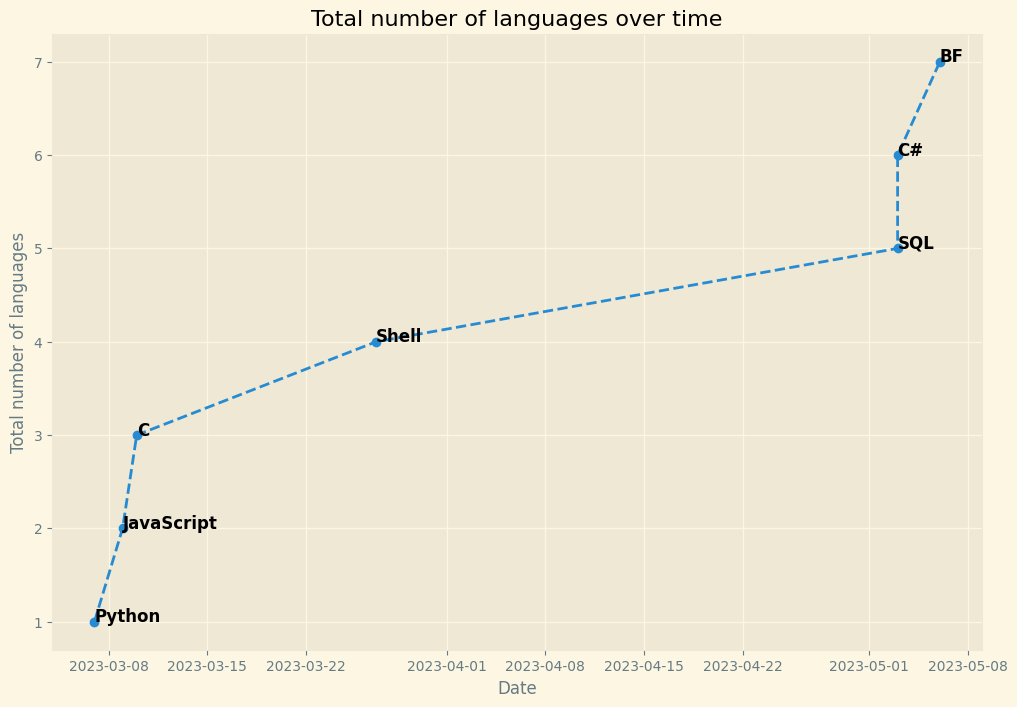

In [76]:
# Plot total languages over time
plt.figure(figsize=(12, 8))
plt.plot(first_appearance_df['first_appearance'], first_appearance_df['total_languages'], marker='o', linestyle='--')
plt.ylabel('Total number of languages')
plt.xlabel('Date')
plt.title('Total number of languages over time')

# Add labels to the points
for i, language in enumerate(first_appearance_df['language']):
    plt.annotate(language, (first_appearance_df['first_appearance'].iloc[i], first_appearance_df['total_languages'].iloc[i]), weight='bold', fontsize=12)

#### Representation of Languages Over Time

In [77]:
language_representation_df = codewars_df[['problem_id', 'language', 'date_time']]
language_representation_df['date_time'] = language_representation_df['date_time'].dt.date
language_representation_df.sort_values('date_time', inplace=True)
language_representation_df.head()

/tmp/ipykernel_23283/3431246607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_representation_df['date_time'] = language_representation_df['date_time'].dt.date
/tmp/ipykernel_23283/3431246607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_representation_df.sort_values('date_time', inplace=True)


,problem_id,language,date_time
141,5556282156230d0e5e000089,Python,2023-03-07
139,53af2b8861023f1d88000832,Python,2023-03-07
32,5641275f07335295f10000d0,Python,2023-03-07
134,5412509bd436bd33920011bc,Python,2023-03-07
163,5641275f07335295f10000d0,Python,2023-03-07


In [78]:
# Now we need to count the number of problems per language per day
language_representation_df = language_representation_df.groupby(['language', 'date_time']).agg({'problem_id': 'count'}).reset_index()
# Now we can apply a cumsum
language_representation_df['total_problems'] = language_representation_df.groupby('language')['problem_id'].cumsum()
language_representation_df.describe()

,problem_id,total_problems
count,56.000000,56.000000
mean,5.214286,40.857143
std,5.904434,41.684716
min,1.000000,2.000000
25%,1.750000,10.750000
50%,3.000000,29.500000
75%,6.250000,56.250000
max,29.000000,173.000000


In [79]:
language_representation_df.head()

,language,date_time,problem_id,total_problems
0,BF,2023-05-06,2,2
1,BF,2023-05-07,1,3
2,BF,2023-05-09,2,5
3,BF,2023-05-15,6,11
4,C,2023-03-10,2,2


In [80]:
from datetime import timedelta

# Add values to the chart where there will be holes (from problem count not starting at 0, from problems not being completed on the last day of the dataset)
max_date = language_representation_df['date_time'].max()
for language in language_representation_df['language'].unique():
    # Entry with the max date of the entire dataframe and the max total_problems for each language
    max_total_problems = language_representation_df[language_representation_df['language'] == language]['total_problems'].max()
    max_date_row = [language, max_date, "", max_total_problems]
    language_representation_df.loc[len(language_representation_df)] = max_date_row
    
    # An entry for each language at the day before the first appearance with 0 total_problems
    first_appearance = first_appearance_df[first_appearance_df['language'] == language]['first_appearance'].values[0]
    min_date_row = [language, first_appearance - timedelta(days=1), "", 0]
    language_representation_df.loc[len(language_representation_df)] = min_date_row

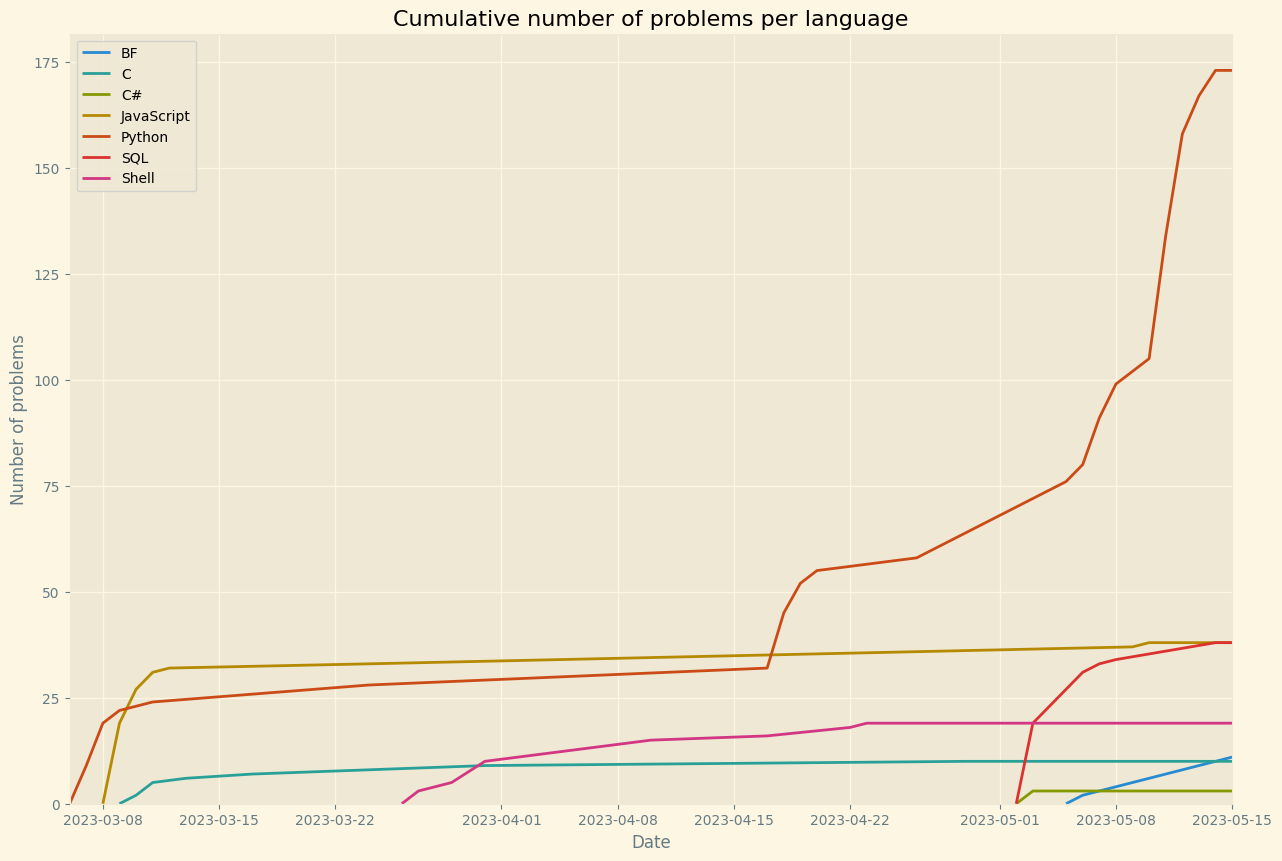

In [81]:
# Plot line chart
fig, ax = plt.subplots(figsize=(15, 10))
for key, grp in language_representation_df.groupby(['language']):
    ax = grp.plot(ax=ax, kind='line', x='date_time', y='total_problems', label=key)
plt.legend(loc='best')
plt.title('Cumulative number of problems per language')
plt.xlabel('Date')
plt.ylabel('Number of problems')
min_date = language_representation_df['date_time'].min()
plt.xlim(min_date, max_date)
plt.ylim(0, language_representation_df['total_problems'].max() * 1.05)
plt.show()

### Analysis of Tags

In [82]:
import ast
# Create a series by extracting the tags column as a list
tags_series = pd.Series(codewars_df['tags'].apply(ast.literal_eval))

#### Tag Frequency

In [83]:
# Let's get a list of tags
tag_counts = {}
for tag_list in tags_series:
    for tag in tag_list:
        if tag not in tag_counts:
            tag_counts[tag] = 1
        else:
            tag_counts[tag] += 1
            
# Get tag_counts sorted by value
sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

[('Fundamentals', 255),
 ('Strings', 83),
 ('Arrays', 59),
 ('Algorithms', 53),
 ('Mathematics', 33),
 ('Regular Expressions', 31),
 ('SQL', 23),
 ('Lists', 12),
 ('Databases', 10),
 ('Geometry', 5),
 ('Data Science', 5),
 ('Puzzles', 4),
 ('Data Structures', 4),
 ('Games', 3),
 ('Date Time', 3),
 ('NumPy', 3),
 ('ASCII Art', 3),
 ('Filtering', 2),
 ('Parsing', 2),
 ('Sorting', 2),
 ('Object-oriented Programming', 2),
 ('Number Theory', 2),
 ('Logic', 2),
 ('Algebra', 2),
 ('Linear Algebra', 1),
 ('Combinatorics', 1),
 ('Graph Theory', 1),
 ('Cryptography', 1),
 ('Debugging', 1),
 ('Dynamic Programming', 1),
 ('Performance', 1),
 ('Design Patterns', 1),
 ('Permutations', 1),
 ('Refactoring', 1),
 ('Binary', 1),
 ('Ciphers', 1),
 ('Restricted', 1),
 ('Recursion', 1)]

In [84]:
# Clean up the tags:
# Remove tags with 2 or less occurances
# Remove "Fundamentals" because it's massively over-represented
# Remove SQL because the SQL tag is only used for SQL specific problems
tag_counts = {k: v for k, v in tag_counts.items() if v > 2 and k != 'Fundamentals' and k != 'SQL'}

#### Lollipop chart 

Text(0.5, 1.0, 'Number of problems per tag')

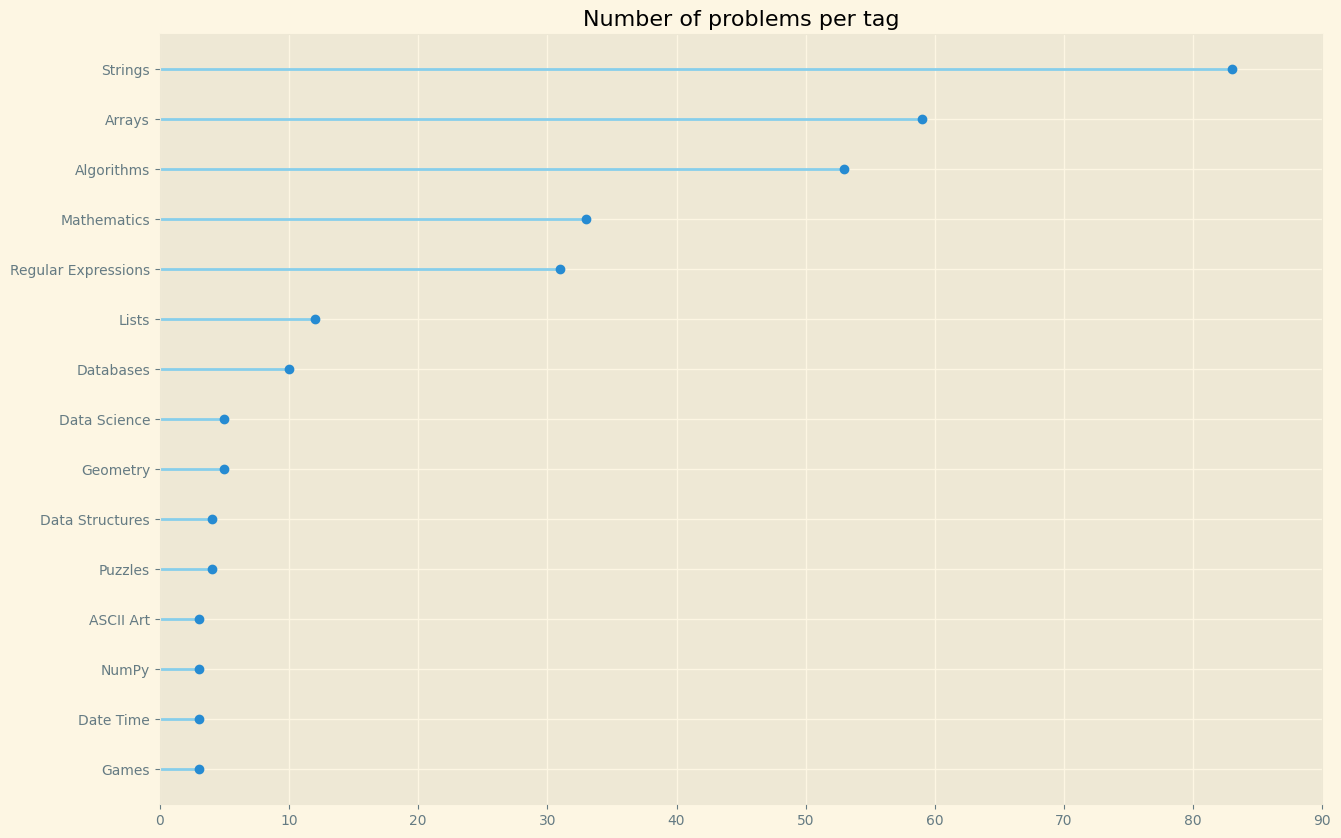

In [151]:
# Create a dataframe
# Reorder it following the values:
tags_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['count']).sort_values(by='count')
my_range=range(1,len(tags_df.index)+1)
fig = plt.subplots(figsize=(15, 10))
plt.hlines(y=my_range, xmin=0, xmax=tags_df['count'], color='skyblue')
plt.plot(tags_df['count'], my_range, "o")

# Round the max value to the nearest 10
plt.xlim(0, round(tags_df['count'].max()/10 + 1) * 10)
plt.yticks(my_range, tags_df.index);

plt.title('Number of problems per tag')

# Make the plot
# plt.stem(ordered_df['values'])
# plt.xticks( my_range, ordered_df['group'])

#### Top Tag Representation Over Time

In [86]:
# Top n tags
num_tags = 6
top_tags = [tag for tag in sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)[:num_tags]]
# Get the tag names
top_tags = [tag[0] for tag in top_tags]

# Now we can analysis the tag representation over time in a new dataframe
tag_representation_df = codewars_df[['date_time', 'tags']].copy()

# Convert date time to just date
tag_representation_df['date_time'] = tag_representation_df['date_time'].dt.date
tag_representation_df['date_time'] = pd.to_datetime(tag_representation_df['date_time'])
tag_representation_df.rename(columns={'date_time': 'date'}, inplace=True)

# Convert tags to a list then create columns for each tag
tag_representation_df['tags'] = tag_representation_df['tags'].apply(ast.literal_eval)
for tag in top_tags:
    tag_representation_df[tag] = tag_representation_df['tags'].apply(lambda x: int(tag in x))

# Drop the original tags column
tag_representation_df.drop('tags', axis=1, inplace=True)

tag_representation_df.shape

(292, 7)

In [87]:
tag_representation_df.head()

,date,Strings,Arrays,Algorithms,Mathematics,Regular Expressions,Lists
0,2023-04-08,0,0,0,0,0,0
1,2023-03-27,1,0,0,0,0,0
2,2023-04-08,0,0,0,0,0,0
3,2023-04-17,0,0,1,1,0,0
4,2023-03-31,0,0,0,0,0,0


In [88]:
# Group by date
tag_representation_df = tag_representation_df.groupby('date').sum()

In [89]:
tag_representation_df.shape

(37, 6)

In [90]:
tag_representation_df.head()

,Strings,Arrays,Algorithms,Mathematics,Regular Expressions,Lists
date,,,,,,
2023-03-07,3,2,2,0,0,0
2023-03-08,2,2,7,2,0,1
2023-03-09,4,10,3,2,0,2
2023-03-10,4,2,0,1,0,0
2023-03-11,3,0,2,0,0,0


In [91]:
# Final step is to change the tag columns to sums
for tag in top_tags:
    tag_representation_df[tag] = tag_representation_df[tag].cumsum()
    
tag_representation_df.head()

,Strings,Arrays,Algorithms,Mathematics,Regular Expressions,Lists
date,,,,,,
2023-03-07,3,2,2,0,0,0
2023-03-08,5,4,9,2,0,1
2023-03-09,9,14,12,4,0,3
2023-03-10,13,16,12,5,0,3
2023-03-11,16,16,14,5,0,3


Text(0.5, 1.0, 'Zoom')

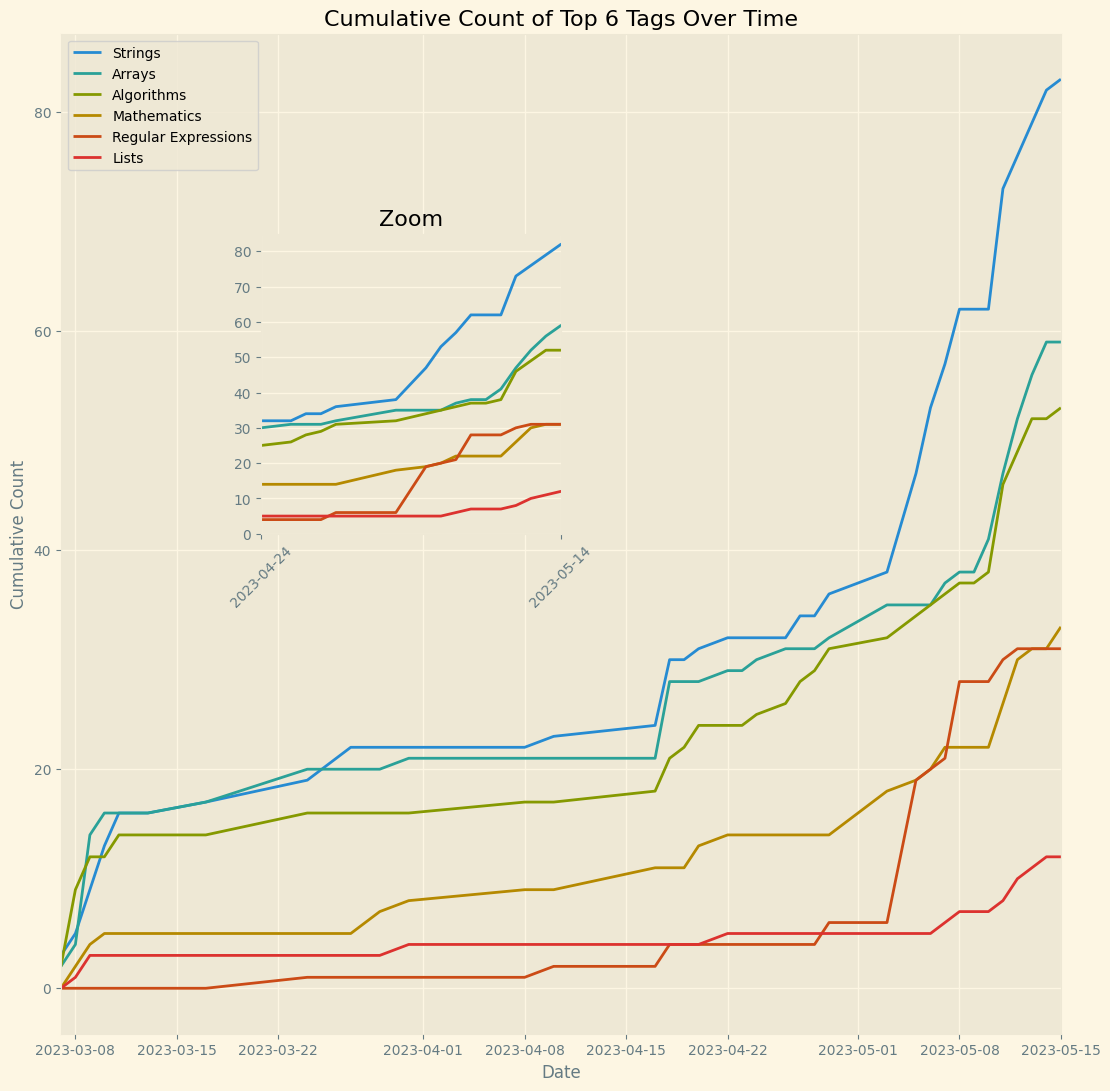

In [92]:
# Side note: I can't believe I actually got that to work
# Now we can plot the data
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0.2, 0.5, 0.3, 0.3])
ax1.set(xlabel='Date', ylabel='Cumulative Count', title=f'Cumulative Count of Top {num_tags} Tags Over Time')
ax1.plot(tag_representation_df)
ax2.plot(tag_representation_df)
ax1.legend(top_tags)
# Set limits for first plot (from first date to last date)
ax1.set_xlim([pd.Timestamp(tag_representation_df.index[0]), pd.Timestamp(tag_representation_df.index[-1])])
ax2.set_ylim([0, 250])
# Set limits for the second plot
ax2_start_date = pd.Timestamp('2023-04-24')
ax2_end_date = pd.Timestamp('2023-05-14')
ax2.set_xlim([ax2_start_date, ax2_end_date])
ax2.set_ylim([0, 85])
# Set ticks for the second plot
ax2.set_xticks([ax2_start_date, ax2_end_date], freq='D')
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_title('Zoom')

#### Tags vs Language Heatmap

In [127]:
# We'll make a new dataframe with language counts and tag list
language_tags_df = codewars_df[['language', 'tags']].copy()
language_tags_df['tags'] = language_tags_df['tags'].apply(ast.literal_eval)

In [128]:
# Create a dictionary with a list of dictionaries for each language
language_tags_dict = {
    language: {} for language in language_tags_df['language'].unique()
}
language_tags_dict

{'Shell': {},
 'Python': {},
 'BF': {},
 'SQL': {},
 'JavaScript': {},
 'C': {},
 'C#': {}}

In [129]:
# Now we can use iterrows to start filling in the dictionary
# We'll also blacklist some tags that are too common or not useful
blacklisted_tags = ['Fundamentals', 'SQL']

for index, row in language_tags_df.iterrows():
    language = row['language']
    tags = row['tags']
    for tag in tags:
        if tag in blacklisted_tags:
            continue
        if tag not in language_tags_dict[language]:
            language_tags_dict[language][tag] = 1
        else:
            language_tags_dict[language][tag] += 1

In [130]:
# There's some clutter in the dictionary, so we'll filter out some less represented tags
lowest_tag_count = 3

for language in language_tags_dict:
    language_tags_dict[language] = {tag: count for tag, count in language_tags_dict[language].items() if count > lowest_tag_count}

# Then let's have a look at the counts
for language in language_tags_dict:
    print(language)
    print("Number of tags:", len(language_tags_dict[language]))

Shell
Number of tags: 2
Python
Number of tags: 7
BF
Number of tags: 1
SQL
Number of tags: 4
JavaScript
Number of tags: 2
C
Number of tags: 1
C#
Number of tags: 0


In [131]:
# Now we can create a dataframe from the dictionary
language_tags_df = pd.DataFrame.from_dict(language_tags_dict, orient='index')

In [132]:
language_tags_df.head()

,Strings,Mathematics,Regular Expressions,Algorithms,Lists,Arrays,Data Structures,Databases,Data Science
Shell,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Python,59.0,16.0,28.0,47.0,8.0,42.0,4.0,NaN,NaN
BF,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SQL,5.0,5.0,NaN,NaN,NaN,NaN,NaN,10.0,5.0
JavaScript,7.0,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN


In [133]:
# Replace NaN with 0
language_tags_df.fillna(0, inplace=True)

<AxesSubplot:>

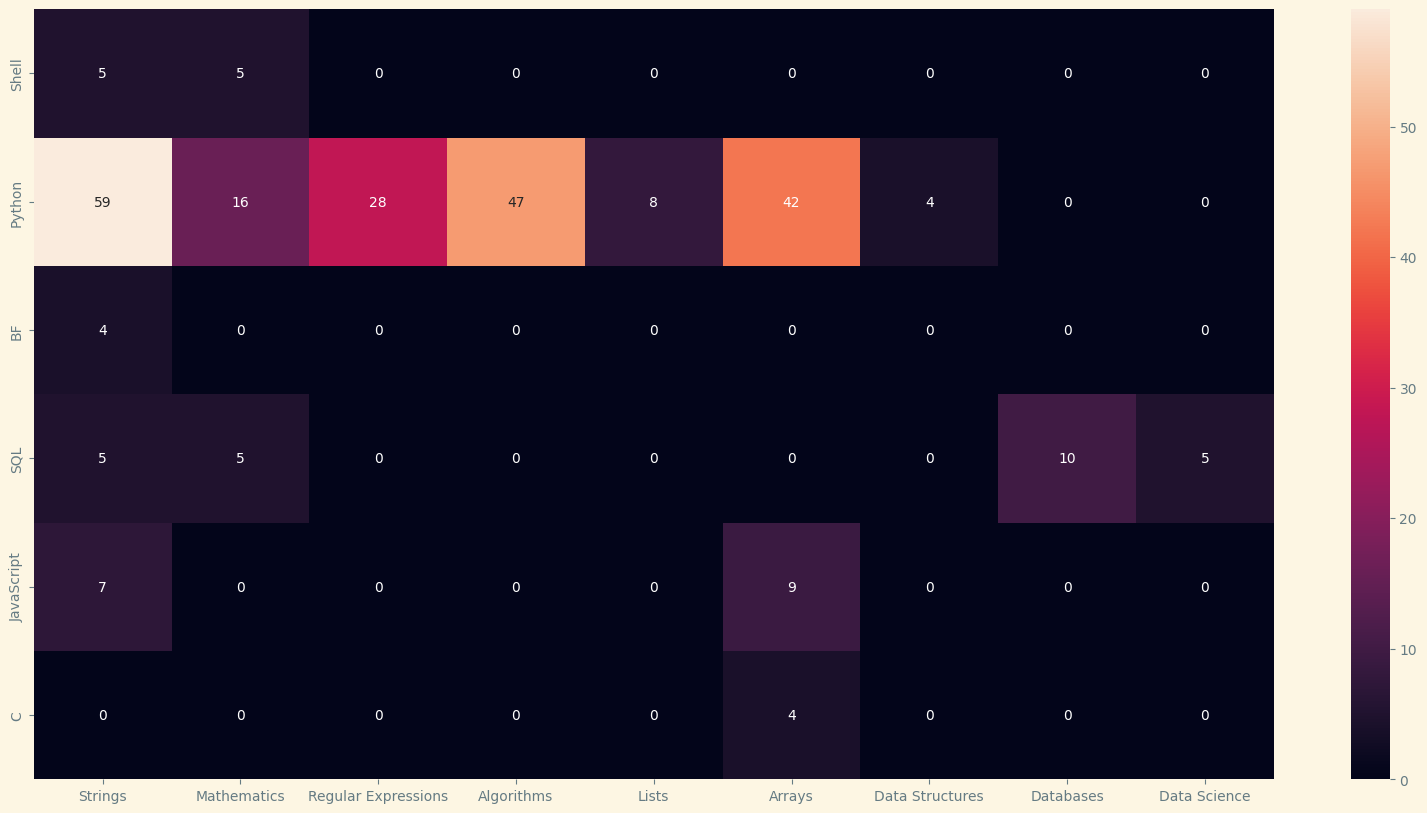

In [134]:
# Now let's create a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(language_tags_df, annot=True, fmt='g', cmap='rocket')

# TODO!

Next thing to do is write a function to scrape instead of hard-coding
The test scraper and full scraper run on different code
I can include the scraper as a module so it's tucked out of the way of the notebook

The heatmap doesn't really make sense in tag analysis, sholuld use a bar plot instead

Fundamentals tag should probably be discarded as an outlier because it's in nearly all problems - we'll calculate the percentage of problems that have that tag

Add labels to the languages chart

Tidy up the notebook, especially the URLs because there's a massive list of output
Add some additional commentary too

The SQL tags should be discarded as well because they only appear in SQL. We'll get a much better heatmap if we do that and discard fundamentals tag


A lollipop plot would be a nifty way of showing the top tags for each language
https://www.python-graph-gallery.com/lollipop-plot/